In [ ]:
!wget https://www.dropbox.com/sh/1vdi3542d9vtc9g/AAA9YVAgGpJ28lmkCMkYvd_5a?dl=0

--2021-05-09 07:54:46--  https://www.dropbox.com/sh/1vdi3542d9vtc9g/AAA9YVAgGpJ28lmkCMkYvd_5a?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/1vdi3542d9vtc9g/AAA9YVAgGpJ28lmkCMkYvd_5a [following]
--2021-05-09 07:54:47--  https://www.dropbox.com/sh/raw/1vdi3542d9vtc9g/AAA9YVAgGpJ28lmkCMkYvd_5a
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce290b0a248a1ca5905c430dfeb.dl.dropboxusercontent.com/zip_download_get/AxiRG3BCPlZhC47Exq7WoAnCNRkBwWjlf9AW4gy-cnXzpWljugwZWPRbzt07EjPQnMrWx1eY50AaG3N9KgKR8nD892wR5FZoidHGv2ni_WGl4Q [following]
--2021-05-09 07:54:50--  https://uce290b0a248a1ca5905c430dfeb.dl.dropboxusercontent.com/zip_download_get/AxiRG3BCPlZhC47Exq7WoAnCNRkBwWjlf9AW4gy-cnXzpWljugwZWPRbzt07EjPQnMrWx1eY50AaG3N9K

In [ ]:
!unzip '/content/AAA9YVAgGpJ28lmkCMkYvd_5a?dl=0'

Archive:  /content/AAA9YVAgGpJ28lmkCMkYvd_5a?dl=0
mapname:  conversion of  failed
   creating: COVID/
   creating: NORMAL/
 extracting: README.md.txt           
   creating: Viral Pneumonia/
 extracting: COVID/COVID (9).png     
 extracting: COVID/COVID (5).png     
 extracting: COVID/COVID (6).png     
 extracting: COVID/COVID (8).png     
 extracting: COVID/COVID (2).png     
 extracting: COVID/COVID (3).png     
 extracting: COVID.metadata.xlsx     
 extracting: COVID/COVID (7).png     
 extracting: COVID/COVID (4).png     
 extracting: COVID/COVID (1).png     
 extracting: COVID/COVID (46).png    
 extracting: COVID/COVID (64).png    
 extracting: COVID/COVID (84).png    
 extracting: COVID/COVID (36).png    
 extracting: COVID/COVID (66).png    
 extracting: COVID/COVID (76).png    
 extracting: COVID/COVID (94).png    
 extracting: COVID/COVID (67).png    
 extracting: COVID/COVID (57).png    
 extracting: COVID/COVID (19).png    
 extracting: NORMAL.metadata.xlsx    
 extracting

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import time
import keras.backend as K
import os
import shutil
import glob
import random

from keras.optimizers.schedules import InverseTimeDecay,ExponentialDecay
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.utils import Progbar

from keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from keras.optimizers import Adam,RMSprop
from keras.applications.densenet import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.metrics import CategoricalAccuracy, Precision, Recall
from keras.layers import Dense, Conv2D, BatchNormalization, MaxPool2D, AveragePooling2D, Flatten, Input,GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model
from keras.optimizers.schedules import InverseTimeDecay,ExponentialDecay

from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

In [ ]:
path = "/content/"

classesPath = ['COVID', 'Viral Pneumonia', 'NORMAL']

val_ratio = 0.1
test_ratio = 0.05

for cls in classesPath:
    os.makedirs('./train/' + cls)
    os.makedirs('./val/' + cls)
    os.makedirs('./test/' + cls)

    src = path + cls

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames) * (1 - (val_ratio + test_ratio))), 
                                                               int(len(allFileNames) * (1 - test_ratio))])

    train_FileNames = [src + '/' + name for name in train_FileNames.tolist()]
    val_FileNames = [src + '/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src + '/' + name for name in test_FileNames.tolist()]

    print('Total ', str(cls), len(allFileNames))
    print('Training', len(train_FileNames))
    print('Validation', len(val_FileNames))
    print('Testing', len(test_FileNames))
    print("\n")

    for name in train_FileNames:
        shutil.copy(name, './train/' + cls)

    for name in val_FileNames:
        shutil.copy(name, './val/' + cls)

    for name in test_FileNames:
        shutil.copy(name, './test/' + cls)

Total  COVID 1199
Training 1019
Validation 120
Testing 60


Total  Viral Pneumonia 1345
Training 1143
Validation 134
Testing 68


Total  NORMAL 1341
Training 1139
Validation 134
Testing 68




In [ ]:
path_train = "./train"
path_val = "./val"
path_test = "./test"

batch_size = 128
target_size = (100, 100)

train_data_gen = ImageDataGenerator(rescale = 1./99,
                                    rotation_range = 12,
                                    zoom_range = 0.1)

test_data_gen = ImageDataGenerator(rescale = 1./99)

ds_train = train_data_gen.flow_from_directory(directory = path_train,
                                              color_mode = "rgb",
                                              batch_size = batch_size,
                                              target_size = target_size,
                                              shuffle = True)

ds_val = test_data_gen.flow_from_directory( directory = path_val,
                                            color_mode = "rgb",
                                            batch_size = batch_size,
                                            target_size = target_size,
                                            shuffle = True)   

ds_test = test_data_gen.flow_from_directory(directory = path_test,
                                            color_mode = "rgb",
                                            batch_size = 16,
                                            target_size = target_size,
                                            shuffle = True)

In [ ]:
@tf.function
def train_one_step(x_batch, y_batch, metric, model, loss_function):
    # Gradient for derivative:
    with tf.GradientTape() as tape:
        # Prediction for each batch:
        y_hat = model(x_batch, training = True)
        # Categorical Cross Entropy Loss:
        loss = loss_function(y_batch, y_hat)
    # Get derivative of all trainable weights to loss function:
    gradients = tape.gradient(loss, model.trainable_weights)
    # Optimizer = ADAM.
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    metric.update_state(y_batch, y_hat)
    return loss

@tf.function
def val_one_step(x_batch, y_batch, metric, model, loss_function):
    y_hat = model(x_batch,training = False)
    loss = loss_function(y_batch, y_hat)
    metric.update_state(y_batch, y_hat)
    return loss


In [ ]:
def train(model, optimizer, metric, metric_val,epochs):
    l=[]
    l1=[]
    a=[]
    a1=[]
    losses = []
    losses_val = []
    accuracies = []
    accuracies_val = []
    best_loss=999999
    loss_function = CategoricalCrossentropy()
    for epoch in range(epochs):
        print("\nepoch {}/{}".format(epoch + 1, epochs))
        batch_num = 0
        metric_names = [metric.name, "loss"]
        loss_train=0
        for batch_num, (x_batch_train, y_batch_train) in enumerate(ds_train):
            loss_train += train_one_step(x_batch_train, y_batch_train, metric, model, loss_function)
            values = [('acc',metric.result().numpy()), ('loss', loss_train)]
            accuracy = metric.result().numpy()
            accuracies.append(accuracy)
            losses.append(loss_train)
            if batch_num == (3108 // batch_size):
                break

        print("\nepoch {}/{}".format(epoch + 1, epochs))
        metric_val_names = [metric_val.name, "val_loss"]
        loss_val=0
        for val_batch_num,(x_batch_val,y_batch_val) in enumerate(ds_val):
            loss_val += val_one_step(x_batch_val, y_batch_val, metric_val, model, loss_function)
            values = [('val_acc',metric_val.result().numpy()), ('val_loss', loss_val)]
            accuracy_val = metric_val.result().numpy()
            accuracies_val.append(accuracy_val)
            losses_val.append(loss_val)
            if val_batch_num == (388//batch_size):
                break

        if(best_loss>loss_val):
            best_weights=model.get_weights()
            model.save_weights(model.name+".h5")
            best_loss=loss_val
        
            
        
        print(metric.name + " over epoch " + str(epoch + 1) + " = " + str(accuracy) + " and " + metric_val.name + " = " + str(accuracy_val))
        print("loss over epoch " + str(epoch + 1) + " = " + str(loss_train.numpy()) + " and val_loss = " + str(loss_val.numpy()))
        l.append(float(loss_train.numpy()))
        print(l)
        l1.append(float(loss_val.numpy()))
        print(l1)
        a.append(float(accuracy))
        print(a)
        a1.append(float(accuracy_val))
        print(a1) 
        metric.reset_states()
        metric_val.reset_states()

        
        
    model.set_weights(best_weights)
    return losses, loss_val, accuracies, accuracies_val

In [ ]:
def evaluate(model, metric):
    losses = []
    accuracies = []
    loss_function = CategoricalCrossentropy()
    batch_num = 0
    y_pred=np.array([])
    y_test=np.array([])
    metric_names = [metric.name, "loss"]
    for batch_num, (x_batch_test,y_batch_test) in enumerate(ds_test):
        loss_test = val_one_step(x_batch_test, y_batch_test, metric, model, loss_function)
        values = [('acc',metric.result().numpy()), ('loss', loss_test)]
        y_pred=np.append(y_pred,model.predict(x_batch_test))
        y_test=np.append(y_test,y_batch_test)
        if batch_num == (196 // 16):
            break
    y_pred = np.reshape(y_pred,(196,3))
    y_test = np.reshape(y_test,(196,3))
    y_pred = np.argmax(y_pred,axis=1)
    y_test = np.argmax(y_test,axis=1)
    report = classification_report(y_true=y_test,y_pred=y_pred)
    metric.reset_states()
    confusion_mat = confusion_matrix(y_pred = y_pred, y_true = y_test)
    return report, confusion_mat


In [ ]:
model_DenseNet121 = DenseNet121(include_top = False, weights = "imagenet", input_shape = (100, 100, 3))
model_DenseNet121.trainable = False

x = model_DenseNet121.layers[-115].output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)

y_hat = Dense(3,'softmax')(x)

model_DenseNet121 = Model(inputs = model_DenseNet121.input, outputs = y_hat,name="DenseNet121")

29089792/29084464 [==============================] - 0s 0us/step


In [ ]:
model_DenseNet121.summary()

Model: "DenseNet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 50, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
start = time.time()
optimizer = Adam()
metric = CategoricalAccuracy(name = "Accuracy")
metric_val = CategoricalAccuracy(name = "Val_Accuracy")

losses, accuracy, losses_val, accuracies_val = train(model_DenseNet121, optimizer, metric, metric_val, 50)
end = time.time()


epoch 1/50

epoch 1/50
Accuracy over epoch 1 = 0.8334375 and Val_Accuracy = 0.91752577
loss over epoch 1 = 12.897052 and val_loss = 1.2328188
[12.897051811218262]
[1.232818841934204]
[0.8334375023841858]
[0.9175257682800293]

epoch 2/50

epoch 2/50
Accuracy over epoch 2 = 0.9231012 and Val_Accuracy = 0.91237116
loss over epoch 2 = 5.101589 and val_loss = 0.75783354
[12.897051811218262, 5.101589202880859]
[1.232818841934204, 0.7578335404396057]
[0.8334375023841858, 0.9231011867523193]
[0.9175257682800293, 0.9123711585998535]

epoch 3/50

epoch 3/50
Accuracy over epoch 3 = 0.94043493 and Val_Accuracy = 0.943299
loss over epoch 3 = 4.1194825 and val_loss = 0.54321146
[12.897051811218262, 5.101589202880859, 4.119482517242432]
[1.232818841934204, 0.7578335404396057, 0.5432114601135254]
[0.8334375023841858, 0.9231011867523193, 0.9404349327087402]
[0.9175257682800293, 0.9123711585998535, 0.9432989954948425]

epoch 4/50

epoch 4/50
Accuracy over epoch 4 = 0.94390166 and Val_Accuracy = 0.94329

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        60
           1       0.94      0.97      0.96        68
           2       0.94      0.94      0.94        68

    accuracy                           0.96       196
   macro avg       0.96      0.96      0.96       196
weighted avg       0.96      0.96      0.96       196



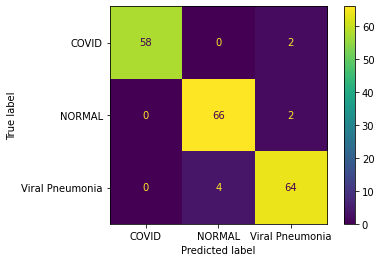

In [ ]:
report, confusion_mat = evaluate(model_DenseNet121, metric)

print(report)
ConfusionMatrixDisplay(confusion_matrix = confusion_mat,display_labels=ds_train.class_indices).plot()

In [ ]:
end - start

3270.7705867290497

In [ ]:
report = classification_report(y_true=y_test,y_pred=y_pred)
metric.reset_states()
confusion_mat = confusion_matrix(y_pred = y_pred, y_true = y_test)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        60
           1       0.96      0.99      0.97        68
           2       0.99      0.97      0.98        68

    accuracy                           0.98       196
   macro avg       0.98      0.98      0.98       196
weighted avg       0.98      0.98      0.98       196



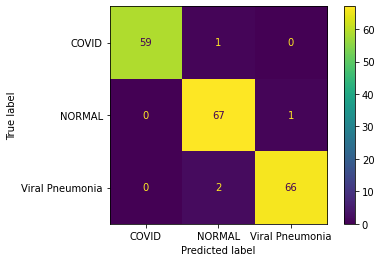

In [ ]:
print(report)
ConfusionMatrixDisplay(confusion_matrix = confusion_mat,display_labels=ds_train.class_indices).plot()


In [ ]:
l_v = [1.232818841934204, 0.7578335404396057, 0.5432114601135254, 0.49487927556037903, 0.4252058267593384, 0.413251668214798, 0.5530105233192444, 0.5173606872558594, 0.5255869030952454, 1.0839678049087524, 0.42939820885658264, 0.5311765670776367, 0.37451860308647156, 1.693028450012207, 1.3092827796936035, 0.9209522008895874, 0.4273473918437958, 0.4059302806854248, 0.4280805289745331, 0.36930906772613525, 0.36444658041000366, 0.3429732918739319, 0.5664054155349731, 0.3673174977302551, 0.37804561853408813, 0.3612237870693207, 0.48041871190071106, 0.4671517610549927, 0.9571182131767273, 0.36992061138153076, 0.3583841621875763, 0.4331865608692169, 0.3583025634288788, 0.3572387397289276, 1.5845917463302612, 0.4050789177417755, 0.601905345916748, 0.45326387882232666, 0.5036172270774841, 1.3463411331176758, 2.6543867588043213, 0.4233661890029907, 0.5128579139709473, 0.42205509543418884, 0.4464532732963562, 0.4622519016265869, 0.4608987271785736, 0.4271681606769562, 0.581406831741333, 1.1696745157241821] 
l = [12.897051811218262, 5.101589202880859, 4.119482517242432, 3.937039613723755, 3.26037335395813, 3.6742594242095947, 3.2383437156677246, 2.643528938293457, 3.009190320968628, 2.575286388397217, 2.6923277378082275, 2.6342334747314453, 2.7874746322631836, 2.4882314205169678, 2.6280128955841064, 2.6255271434783936, 2.263415575027466, 2.259465456008911, 2.1251883506774902, 2.3517377376556396, 2.2156009674072266, 2.3187568187713623, 1.7587924003601074, 1.923018455505371, 1.9359190464019775, 1.965442180633545, 1.7844480276107788, 1.7798030376434326, 1.89302396774292, 2.1068148612976074, 1.9464362859725952, 2.2108211517333984, 2.204943895339966, 1.7485204935073853, 1.8446749448776245, 1.7833764553070068, 1.4553152322769165, 1.7278618812561035, 1.4892070293426514, 1.8127691745758057, 1.5176353454589844, 1.7058043479919434, 1.4819884300231934, 1.4208521842956543, 1.557700514793396, 1.7427419424057007, 1.4578208923339844, 1.3329843282699585, 1.3360565900802612, 1.3442134857177734]
a = [0.8334375023841858, 0.9231011867523193, 0.9404349327087402, 0.9439016580581665, 0.9549322128295898, 0.9445319771766663, 0.9533564448356628, 0.9653325080871582, 0.9552474021911621, 0.9624960422515869, 0.9596596360206604, 0.9628112316131592, 0.9615505933761597, 0.9640718698501587, 0.9612354040145874, 0.9624960422515869, 0.967538595199585, 0.968484103679657, 0.9691144227981567, 0.9691144227981567, 0.967538595199585, 0.9653325080871582, 0.976047933101654, 0.9779388308525085, 0.9697447419166565, 0.968484103679657, 0.9740625023841858, 0.972581148147583, 0.971005380153656, 0.9647021889686584, 0.9678537845611572, 0.965962827205658, 0.9662779569625854, 0.9744721055030823, 0.9732114672660828, 0.9754176139831543, 0.9769933819770813, 0.9766782522201538, 0.977623701095581, 0.9719508290290833, 0.9795146584510803, 0.9744721055030823, 0.9785691499710083, 0.9804601073265076, 0.975102424621582, 0.9757327437400818, 0.977623701095581, 0.9814056158065796, 0.9814056158065796, 0.9801449775695801]
a_v = [0.9175257682800293, 0.9123711585998535, 0.9432989954948425, 0.9432989954948425, 0.9484536051750183, 0.9536082744598389, 0.9484536051750183, 0.9561855792999268, 0.9432989954948425, 0.9561855792999268, 0.9510309100151062, 0.9432989954948425, 0.9664948582649231, 0.9407216310501099, 0.9355670213699341, 0.9587628841400146, 0.9536082744598389, 0.9664948582649231, 0.9536082744598389, 0.9639175534248352, 0.9664948582649231, 0.9664948582649231, 0.9484536051750183, 0.9613401889801025, 0.9536082744598389, 0.9639175534248352, 0.9561855792999268, 0.9587628841400146, 0.9613401889801025, 0.9613401889801025, 0.9613401889801025, 0.9613401889801025, 0.9639175534248352, 0.9639175534248352, 0.9639175534248352, 0.9561855792999268, 0.9587628841400146, 0.9639175534248352, 0.9587628841400146, 0.9664948582649231, 0.9613401889801025, 0.9587628841400146, 0.9613401889801025, 0.9587628841400146, 0.9613401889801025, 0.9613401889801025, 0.9613401889801025, 0.9613401889801025, 0.9587628841400146, 0.9613401889801025]

In [ ]:
for i in range(0,len(l)):
  l[i] = round(l[i],4)
  l_v[i] = round(l_v[i],4)
  a[i] = round(a[i],4)
  a_v[i] = round(a_v[i],4)

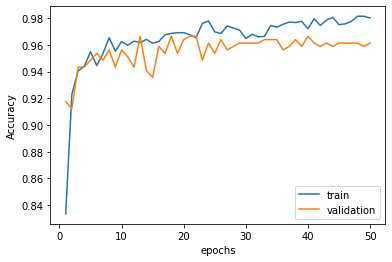

In [ ]:
import matplotlib.pyplot as plt

epoch = [i for i in range(1,51)]
plt.plot(epoch,a)
plt.plot(epoch,a_v)
plt.legend(['train','validation'])
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.show()